# Imports

In [9]:
import time
import fasttext
import random
import warnings
import requests
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

from hmmlearn import hmm
from scipy.sparse import dok_matrix

from torchtext import data, datasets
from torchtext.vocab import FastText

import nltk
from nltk import FreqDist
from nltk.corpus import brown
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm_notebook as tqdm

# Helper Functions

In [6]:
warnings.simplefilter("ignore")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zachary.sheldon/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zachary.sheldon/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to
[nltk_data]     /Users/zachary.sheldon/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package webtext to
[nltk_data]     /Users/zachary.sheldon/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


True

In [10]:
def cosine_similarity(vec_a, vec_b):
    """Compute cosine similarity between vec_a and vec_b"""
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

def tokenize(sentences):
    #Tokenize the sentence
    #from nltk.tokenize library use word_tokenize
    token = word_tokenize(sentences)
    return token


def plot_train_val(x, train, val, train_label, val_label, title, y_label,
                   color):
    plt.plot(x, train, label=train_label, color=color)
    plt.plot(x, val, label=val_label, color=color, linestyle='--')
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel(y_label)
    plt.title(title)


def load_dataset(emb_vectors, sentence_length=50, seed=522):
    TEXT = data.Field(sequential=True,
                    tokenize=tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

    TEXT.build_vocab(train_data, vectors=emb_vectors)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data,
                                                                  valid_data,
                                                                  test_data),
                                                                  batch_size=32,
                                                                  sort_key=lambda x: len(x.text),
                                                                  repeat=False,
                                                                  shuffle=True)
    vocab_size = len(TEXT.vocab)

    print(f'Data are loaded. sentence length: {sentence_length} '
        f'seed: {seed}')

    return TEXT, vocab_size, train_iter, valid_iter, test_iter


def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={ 'id': id }, stream=True)
    token = get_confirm_token(response)

    if token:
        params = { 'id': id, 'confirm': token }
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device

DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


# Sequences, Markov Chains, and HMMs

## Prepare the data

In [13]:
category = ['editorial', 'fiction', 'government', 'news', 'religion']
sentences = brown.sents(categories=category)

lengths = [len(sentence) for sentence in sentences]
lengths = pd.Series(lengths)

corpus_words = []
for sentence in sentences:
    for word in sentence:
        if "''" not in word and "``" not in word:
            corpus_words.append(word)
print(f"Corpus length: {len(corpus_words)}")

Corpus length: 335766


In [15]:
distinct_words = list(set(corpus_words))
word_idx_dict = {word: i for i, word in enumerate(distinct_words)}
distinct_words_count = len(list(set(corpus_words)))
next_word_matrix = np.zeros([distinct_words_count, distinct_words_count])
print("Number of distinct words: " + str(distinct_words_count))

Number of distinct words: 27485


In [16]:
for i, word in enumerate(corpus_words[:-1]):
    first_word_idx = word_idx_dict[word]
    next_word_idx = word_idx_dict[corpus_words[i+1]]
    next_word_matrix[first_word_idx][next_word_idx] +=1

## Markov Chains

A Markov Chain (or Model) is a:
- stochastic model describing a sequence of possible events
- the probability of each event depends only on the state attained in the previous event.
- a countably infinite sequence, in which the chain moves state at discrete time steps, gives a discrete-time Markov chain (DTMC) [vs. a continuous-time process or CTMC].
- The classic formal language model is a Markov Model

*Helpful explanations from [eric mjl's tutorial](https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/#non-autoregressive-homoskedastic-emissions)*!



The simplest Markov models assume that we have a _system_ that contains a finite set of states,
and that the _system_ transitions between these states with some probability at each time step $t$,
thus generating a sequence of states over time.
Let's call these states $S$, where

\begin{equation}
S = \{s_1, s_2, ..., s_n\}
\end{equation}

To keep things simple, let's start with three states:

\begin{equation}
S = \{s_1, s_2, s_3\}
\end{equation}

A Markov model generates a sequence of states, with one possible realization being:

\begin{equation}
\{s_1, s_1, s_1, s_3, s_3, s_3, s_2, s_2, s_3, s_3, s_3, s_3, s_1, ...\}
\end{equation}

And generically, we represent it as a sequence of states $x_t, x_{t+1}... x_{t+n}$. (We have chosen a different symbol to not confuse the "generic" state with the specific realization. Graphically, a plain and simple Markov model looks like the following:

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/cell_chain.png" width="500"/></center>

## Hidden Markov Models

A 1960s advance (by Leonard Baum and colleagues): Hidden Markov Models are:
- a Markov model in which the system modeled is assumed to be a Markov process/chain with unobservable ("hidden") states. 
- HMM assumes there is another surrogate process whose behavior "depends" on the state--you learn about the state by observing the surrogate process. 
- HMMs have successfully been applied in fields where the goal is to recover a data sequence not immediately observable (but other data that depend on the sequence are).
- The first dominant application: Speech and text processing (1970s)

In this sub-section we will use the python library [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#training-hmm-parameters-and-inferring-the-hidden-states), which is part of the *scikit-learn* ecosystem. [nlg-with-hmmlearn](https://github.com/mfilej/nlg-with-hmmlearn) offers useful code snippets to adapt ```hmmlearn``` for text data. Because we are using a package that offers many out of the box implementations for HMMs, we don't have to worry about the states, transition matrices, 

In [24]:
# load the data
sentences = brown.sents(categories=category)
words = [word.lower() for sentence in sentences for word in sentence]
lengths = [len(sentence) for sentence in sentences]
alphabet = set(words)

# Encode words
le = LabelEncoder()
_ = le.fit(list(alphabet))

# Find word freqeuncies
seq = le.transform(words)
features = np.fromiter(seq, np.int64)
features = np.atleast_2d(features).T
fd = FreqDist(seq)

In [25]:
def get_model(num_states):
    print("Initial parameter estimation using built-in method")
    model = hmm.MultinomialHMM(n_components=num_states, init_params='ste')
    return model

In [26]:
def frequencies(num_states):
    print("Initial parameter estimation using relative frequencies")

    frequencies = np.fromiter((fd.freq(i) for i in range(len(alphabet))),
                            dtype=np.float64)
    emission_prob = np.stack([frequencies]*num_states)

    model = hmm.MultinomialHMM(n_components=num_states, init_params='st')
    model.emissionprob_ = emission_prob
    return model

print(frequencies(2))

Initial parameter estimation using relative frequencies
MultinomialHMM(init_params='st', n_components=2)


In [31]:
def run_model(features, length, num_states):
    model = get_model(num_states)
    model = model.fit(features, lengths)
    return model

num_states = 8
model = frequencies(num_states)

Initial parameter estimation using relative frequencies


In [34]:
import pickle

url = "https://osf.io/5k6cs/download"
r = requests.get(url)
with open('model_w2d3_t1.pkl', 'wb') as fd:
    fd.write(r.content)

# Load the pickle file
with open("model_w2d3_t1.pkl", "rb") as file:
    model = pickle.load(file)

In [35]:
def generate_text(model, num_lines = 5, random_len=15):
    for _i in range(num_lines):
        set_seed(_i)
        symbols, _states = model.sample(random_len)

        output = le.inverse_transform(np.squeeze(symbols))
        for word in output:
            print(word, end=" ")
        print()

In [36]:
generate_text(model, num_lines=2, random_len=20)

Random seed 0 has been set.
until 15 manner on of of a in broaden of four and a his expressed he no the . building 
Random seed 1 has been set.
to of more of service aide issue the take two a they and find heroism had to only smu the 


# Word Embeddings


Words or subword units such as morphemes are the basic units that we use to express meaning  in language. The technique of mapping words to vectors of real numbers is known as word embedding. 

Word2vec is based on theories of distributional semantics - words that appear around each other are more likely to mean similar things than words that do not appear around each other. Keeping this in mind, our job is to create a high dimensional space where these semantic relations are preserved. The innovation in word2vec is the realisation that we can use unlabelled, running text in sentences as inputs for a supervised learning algorithm--as a self-supervision task. It is supervised because we use the words in a sentence to serve as positive and negative examples. Let’s break this down:

... "use the kitchen knife to chop the vegetables"…

**C1   C2   C3   T   C4   C5   C6   C7**

Here, the target word is knife, and the context words are the ones in its immediate (6-word) window. 
The first word2vec method we’ll see is called skipgram, where the task is to assign a probability for how likely it is that the context window appears around the target word. In the training process, positive examples are samples of words and their context words, and negative examples are created by sampling from pairs of words that do not appear nearby one another. 

This method of implementing word2vec is called skipgram with negative sampling. So while the algorithm tries to better learn which context words are likely to appear around a target word, it ends up pushing the embedded representations for every word so that they are located optimally (e.g., with minimal semantic distortion). In this process of adjusting embedding values, the algorithm brings semantically similar words close together in the resulting high dimensional space, and dissimilar words far away. 

Another word2vec training method, Continuous Bag of Words (CBOW), works in a similar fashion, and tries to predict the target word, given context. This is converse of skipgram, which tries to predict the context, given the target word. Skip-gram represents rare words and phrases well, often requiring more data for stable representations, while CBOW is several times faster to train than the skip-gram, but with slightly better accuracy for the frequent words in its prediction task. The popular gensim implementation of word2vec has both the methods included.  

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html).  In order to achieve this task we will use [gensim](https://radimrehurek.com/gensim/) library to create word2vec embeddings. Gensim’s word2vec expects a sequence of sentences as its input. Each sentence is a list of words.
Calling `Word2Vec(sentences, iter=1)` will run two passes over the sentences iterator (or, in general iter+1 passes). The first pass collects words and their frequencies to build an internal dictionary tree structure. The second and subsequent passes train the neural model. 
`Word2vec` accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:

`model = Word2Vec(sentences, min_count=10)  # default value is 5`


A reasonable value for min_count is between 0-100, depending on the size of your dataset.

Another parameter is the size of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

`model = Word2Vec(sentences, size=200)  # default value is 100`


Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

`model = Word2Vec(sentences, workers=4) # default = 1 worker = no parallelization`

In [37]:
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion',
            'reviews', 'romance', 'science_fiction']

def create_word2vec_model(category='news', size=50, sg=1, min_count=5):
    try:
        sentences = brown.sents(categories=category)
        model = Word2Vec(sentences, vector_size=size, sg=sg, min_count=min_count)

    except (AttributeError, TypeError):
        raise AssertionError('Input variable "category" should be a string or list,'
        '"size", "sg", "min_count" should be integers')

    return model

def model_dictionary(model):
    words = list(model.wv.key_to_index)
    return words

def get_embedding(word, model):
    if word in model.wv.key_to_index:
        return model.wv[word]
    else:
        return None

In [38]:
all_categories = brown.categories()
all_categories

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [39]:
w2vmodel = create_word2vec_model(all_categories)

In [41]:
print(get_embedding('weather', w2vmodel))

[-0.01204832  0.24035189 -0.21212988 -0.03195301 -0.14969957 -0.36636233
  0.3407559   0.06517834 -0.2534074  -0.12309735 -0.07398735 -0.14453608
  0.29207197  0.03957735 -0.30239803  0.05613162 -0.24732728  0.22789021
 -0.3661873  -0.48592806  0.17726207  0.40249047  0.51738924 -0.11644861
 -0.02835734  0.05922599  0.19145623  0.24651973 -0.32498726  0.09521692
 -0.3187879  -0.27777478  0.19781172 -0.16488162 -0.00515817 -0.22265574
  0.319301    0.16497104  0.01009131 -0.00570928  0.08980659  0.09450565
 -0.21013935  0.17893364  0.4032989   0.38529727  0.16030563 -0.24734533
  0.30041373  0.03173195]


In [42]:
keys = ['voters', 'magic', 'love', 'God', 'evidence', 'administration', 'governments']

## Visualize embedding

In [46]:
def get_cluster_embeddings(keys):
    embedding_clusters = []
    word_clusters = []

    # find closest words and add them to cluster
    for word in keys:
        embeddings = []
        words = []
        if not word in w2vmodel.wv.key_to_index:
            print('The word ', word, 'is not in the dictionary')
            continue

        for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
            words.append(similar_word)
            embeddings.append(w2vmodel.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

    # get embeddings for the words in clusers
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

    return embeddings_en_2d, word_clusters

def tsne_plot_similar_words(title, labels, embedding_clusters,
                            word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word,
                       alpha=0.5,
                       xy=(x[i], y[i]),
                       xytext=(5, 2),
                       textcoords='offset points',
                       ha='right',
                       va='bottom',
                       size=10)
    plt.legend(loc="lower left")
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

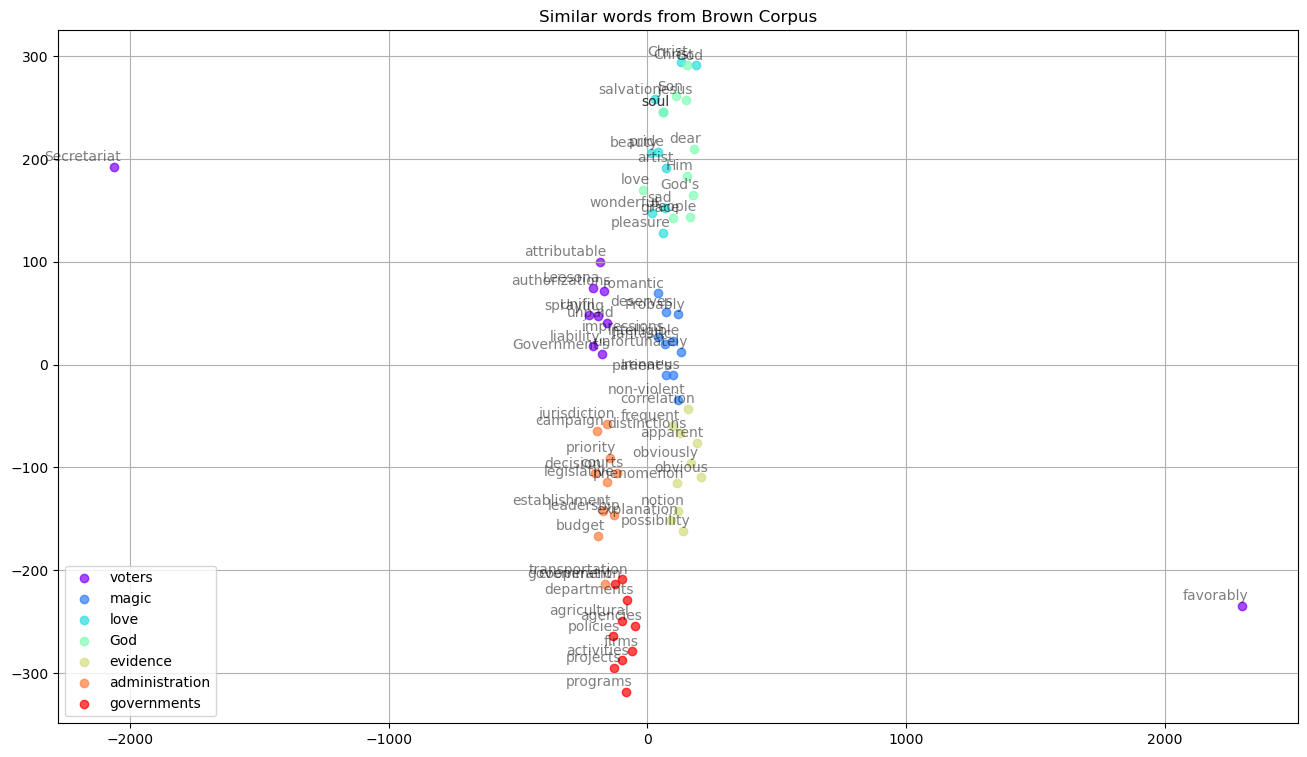

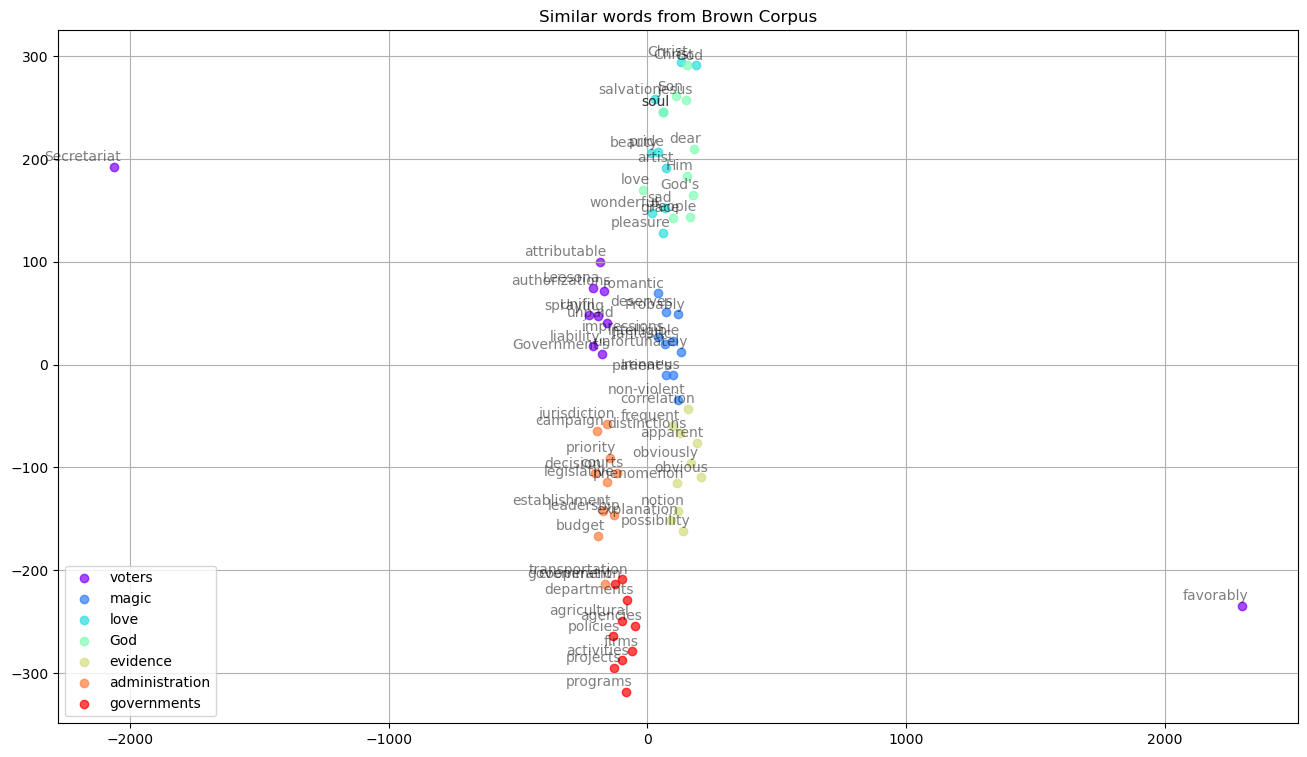

In [47]:
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
tsne_plot_similar_words('Similar words from Brown Corpus', keys, embeddings_en_2d, word_clusters, 0.7)

## Exploring meaning

While word2vec was the method that started it all, research has since boomed, and we now have more sophisticated ways to represent words. One such method is FastText, developed at Facebook AI research, which breaks words into sub-words: such a technique also allows us to create embedding representations for unseen words. In this section, we will explore how semantics and meaning are captured using embedidngs, after downloading a pre-trained FastText model. Downloading pre-trained models is a way for us to plug in word embeddings and explore them without training them ourselves.

In [48]:
import os, io, zipfile
from urllib.request import urlopen

zipurl = 'https://osf.io/w9sr7/download'
print(f"Downloading and unzipping the file... Please wait.")
with urlopen(zipurl) as zipresp:
    with zipfile.ZipFile(io.BytesIO(zipresp.read())) as zfile:
        zfile.extractall('.')
print("Download completed!")

Download completed!


In [49]:
# Load 100 dimension FastText Vectors using FastText library
ft_en_vectors = fasttext.load_model('cc.en.100.bin')
print(f"Length of the embedding is: {len(ft_en_vectors.get_word_vector('king'))}")
print(f"Embedding for the word King is: {ft_en_vectors.get_word_vector('king')}")

Length of the embedding is: 100
Embedding for the word King is: [-0.04045481 -0.10617249 -0.27222311  0.06879666  0.16408321  0.00276707
  0.27080125 -0.05805573 -0.31865698  0.03748008 -0.00254088  0.13805169
 -0.00182498 -0.08973497  0.00319015 -0.19619396 -0.09858181 -0.10103802
 -0.08279888  0.0082208   0.13119364 -0.15956607  0.17203182  0.0315701
 -0.25064597  0.06182072  0.03929246  0.05157393  0.03543638  0.13660161
  0.05473648  0.06072914 -0.04709269  0.17394426 -0.02101276 -0.11402624
 -0.24489872 -0.08576579 -0.00322696 -0.04509873 -0.00614253 -0.05772085
 -0.073414   -0.06718913 -0.06057961  0.10963406  0.1245006  -0.04819863
  0.11408057  0.11081408  0.06752145 -0.01689911 -0.01186301 -0.11716368
 -0.01287614  0.10639337 -0.04243141  0.01057278 -0.0230855  -0.04930984
  0.04717607  0.03696446  0.0015999  -0.02193867 -0.01331578  0.11102925
  0.1686794   0.05814958 -0.00296521 -0.04252011 -0.00352389  0.06267346
 -0.07747819 -0.08959802 -0.02445797 -0.08913022  0.13422231 

In [50]:
ft_en_vectors.get_nearest_neighbors("king", 10)  # Most similar by key

[(0.8168574571609497, 'prince'),
 (0.796097457408905, 'emperor'),
 (0.7907207608222961, 'kings'),
 (0.7655220627784729, 'lord'),
 (0.7435404062271118, 'king-'),
 (0.7394551634788513, 'chieftain'),
 (0.7307553291320801, 'tyrant'),
 (0.7226710319519043, 'conqueror'),
 (0.719561755657196, 'kingly'),
 (0.718187689781189, 'queen')]

## Word Similarity

In [51]:
def getSimilarity(word1, word2):
    v1 = ft_en_vectors.get_word_vector(word1)
    v2 = ft_en_vectors.get_word_vector(word2)
    return cosine_similarity(v1, v2)

print("Similarity between the words King and Queen: ", getSimilarity("king", "queen"))
print("Similarity between the words King and Knight: ", getSimilarity("king", "knight"))
print("Similarity between the words King and Rock: ", getSimilarity("king", "rock"))
print("Similarity between the words King and Twenty: ", getSimilarity("king", "twenty"))

Similarity between the words King and Queen:  0.71818775
Similarity between the words King and Knight:  0.6881009
Similarity between the words King and Rock:  0.28928387
Similarity between the words King and Twenty:  0.19655468


# Neural Net with Word Embeddings

In [52]:
if 'ft_en_vectors' in locals():
    del ft_en_vectors
if 'w2vmodel' in locals():
    del w2vmodel

embedding_fasttext = FastText('simple')

.vector_cache/wiki.simple.vec: 293MB [00:18, 15.5MB/s]                              
100%|██████████| 111051/111051 [00:09<00:00, 11462.88it/s]


In [53]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(embedding_fasttext, seed=SEED)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:06<00:00, 12.6MB/s]


Data are loaded. sentence length: 50 seed: 2021


Define a vanilla neural network with linear layers. Then average the word embeddings to get an embedding for the entire review.
The neural net will have one hidden layer of size 128.

In [54]:
class NeuralNet(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size, embedding_length,
               word_embeddings):
        super(NeuralNet, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weight = nn.Parameter(word_embeddings,
                                                   requires_grad=False)
        self.fc1 = nn.Linear(embedding_length, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):

        input = self.word_embeddings(inputs)  # convert text to embeddings
        # Average the word embeddings in a sentence
        # Use torch.nn.functional.avg_pool2d to compute the averages
        pooled = F.avg_pool2d(input, (input.shape[1], 1)).squeeze(1)

        # Pass the embeddings through the neural net
        # A fully-connected layer
        x = self.fc1(pooled)

        # ReLU activation
        x = F.relu(x)
        # Another fully-connected layer
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

nn_model = NeuralNet(2, 128, 100, 300, TEXT.vocab.vectors)
print(nn_model)

NeuralNet(
  (word_embeddings): Embedding(100, 300)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


## Training and testing

In [55]:
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(epochs):
        # train
        model.train()
        running_loss = 0.
        correct, total = 0, 0
        steps = 0

        for idx, batch in enumerate(train_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            # add micro for coding training loop
            optimizer.zero_grad()
            output = model(text)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()

            # get accuracy
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        train_loss.append(running_loss/len(train_iter))
        train_acc.append(correct/total)

        print(f'Epoch: {epoch + 1}, '
              f'Training Loss: {running_loss/len(train_iter):.4f}, '
              f'Training Accuracy: {100*correct/total: .2f}%')

        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(valid_iter):
                text = batch.text[0]
                target = batch.label
                target = torch.autograd.Variable(target).long()
                text, target = text.to(device), target.to(device)

                optimizer.zero_grad()
                output = model(text)

                loss = criterion(output, target)
                running_loss += loss.item()

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        validation_loss.append(running_loss/len(valid_iter))
        validation_acc.append(correct/total)

        print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, '
               f'Validation Accuracy: {100*correct/total: .2f}%')

    return train_loss, train_acc, validation_loss, validation_acc


def test(model, device, test_iter):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, batch in enumerate(test_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            outputs = model(text)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        acc = 100 * correct / total
        return acc

In [56]:
# Model hyperparameters
learning_rate = 0.0003
output_size = 2
hidden_size = 128
embedding_length = 300
epochs = 15
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)

# Model set-up
nn_model = NeuralNet(output_size,
                     hidden_size,
                     vocab_size,
                     embedding_length,
                     word_embeddings)
nn_model.to(DEVICE)
nn_start_time = time.time()
set_seed(522)
nn_train_loss, nn_train_acc, nn_validation_loss, nn_validation_acc = train(nn_model,
                                                                           DEVICE,
                                                                           train_iter,
                                                                           valid_iter,
                                                                           epochs,
                                                                           learning_rate)
print(f"--- Time taken to train = {(time.time() - nn_start_time)} seconds ---")
test_accuracy = test(nn_model, DEVICE, test_iter)
print(f'\n\nTest Accuracy: {test_accuracy}%')

Random seed 522 has been set.
Epoch: 1, Training Loss: 0.6658, Training Accuracy:  60.63%
Validation Loss: 0.6407, Validation Accuracy:  64.61%
Epoch: 2, Training Loss: 0.6230, Training Accuracy:  66.43%
Validation Loss: 0.6087, Validation Accuracy:  67.29%
Epoch: 3, Training Loss: 0.5980, Training Accuracy:  68.62%
Validation Loss: 0.5935, Validation Accuracy:  68.51%
Epoch: 4, Training Loss: 0.5870, Training Accuracy:  69.30%
Validation Loss: 0.5869, Validation Accuracy:  68.76%
Epoch: 5, Training Loss: 0.5815, Training Accuracy:  69.56%
Validation Loss: 0.5875, Validation Accuracy:  68.81%
Epoch: 6, Training Loss: 0.5771, Training Accuracy:  69.94%
Validation Loss: 0.5834, Validation Accuracy:  69.15%
Epoch: 7, Training Loss: 0.5738, Training Accuracy:  70.19%
Validation Loss: 0.5793, Validation Accuracy:  69.53%
Epoch: 8, Training Loss: 0.5721, Training Accuracy:  70.29%
Validation Loss: 0.6016, Validation Accuracy:  66.68%
Epoch: 9, Training Loss: 0.5707, Training Accuracy:  70.39

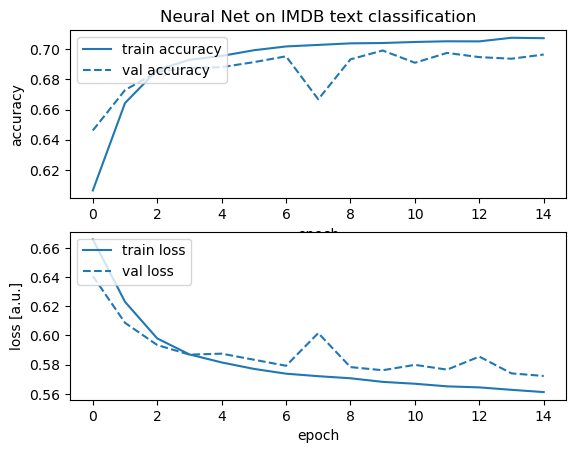

In [57]:
# Plot accuracy curves
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), nn_train_acc, nn_validation_acc,
               'train accuracy', 'val accuracy',
               'Neural Net on IMDB text classification', 'accuracy',
               color='C0')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), nn_train_loss,
               nn_validation_loss,
               'train loss', 'val loss',
               '',
               'loss [a.u.]',
               color='C0')
plt.legend(loc='upper left')
plt.show()

# Recurrent Neural Networks